In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time as ct
import random

pd.options.display.max_columns = None
pd.options.display.max_columns = None

%matplotlib inline

In [2]:
n = 1000
y_true = np.random.rand(n)
y_true = np.vectorize(lambda x: 0 if(x < 0.5) else 1)(y_true)
y_pred = np.random.rand(n)

In [3]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc, log_loss
def binary_classification_eval(y_true,y_pred,prob_thrs=0.5,return_conf_matrix = False,viz = True,):
    '''
    This function evaluates the performance of a classification model and returns evaluation metrics
    Reference: https://www.analyticsvidhya.com/blog/2020/09/precision-recall-machine-learning/
    Parameters:
        y_true (Numpy array) : The ground truth labels given in the dataset
        y_pred (Numpy array) : Model prediction probability
        prob_thrs (numeric)  : Between 0 and 1; 0.5 by default. Predicted values >= threshold are considered as positive and below are negative.
        viz                  : Returns Visualization on the classifier performance along with the metrics
        return_conf_matrix   : Returns the confusion matrix as a dataframe, Default is False
   
    Returns: Dataframe with below metrics to evaluate performance of the classification model
        1. Number of Observations : Rows on which the model is being evaluated, length of the y_pred/y_true series
            i.    Confusion Matrix
            ii.   Accuracy
            iii.  Precision : Ratio between the True Positives and all the Positives
            iv.   Recall : Measure of how accurately our model is able to identify the relevant data
            v.    F1 Score : Takes into account both Recall and Precision
            vi.   ROC AUC : Area under the Receiver Operating Characteristic Curve
            vii.  AUCPR : Area under the Precision-Recall Curve
        2. Log Loss / Binary Cross Entropy:
        3. Categorical Cross Entropy :
   
    '''
    if len(y_true) != len(y_true):
        print('Length of Actual and Predicted lists is unequal. Please check and correct the same!')
        return
   
    n = len(y_true)
    #n_class = sum(np.ones(len(np.unique(y_true))))
    eval_metrics = dict()
   
    pred_df = pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
    pred_df['y_pred_r'] = np.vectorize(lambda x: 0 if (x < prob_thrs) else 1)(y_pred)
    cm = pd.crosstab(pred_df['y_pred_r'],pred_df['y_true'])
    cm.rename_axis('y_pred', inplace=True)
    normalized_cm=(cm-cm.min())/(cm.max()-cm.min())
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
   
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    auc_score = roc_auc_score(y_true, y_pred)
    fpr, tpr, t1 = roc_curve(y_true, y_pred)
    p, r, t2 = precision_recall_curve(y_true, y_pred)
    aucpr = auc(r, p)
    log_loss_ = log_loss(y_true, y_pred)
   
    eval_metrics['Length of Data'] = len(y_true)
    eval_metrics['True Positives'] = TP
    eval_metrics['True Negatives'] = TN
    eval_metrics['False Positives'] = FP
    eval_metrics['False Negatives'] = FN
    eval_metrics['Accuracy'] = accuracy
    eval_metrics['Precision'] = precision
    eval_metrics['Recall'] = recall
    eval_metrics['F1 Score'] = f1_score
    eval_metrics['ROC AUC Score'] = auc_score
    eval_metrics['AUCPR Score'] = aucpr
    eval_metrics['Log Loss / Binary Cross Entropy'] = log_loss_

   
    # Visualizations
    if viz == True:
        fig = plt.figure(figsize=(16,12))
        fig.suptitle('Classification Results')
       
        #Plotting confusion matrix
        ax1 = fig.add_subplot(2, 2, 1)
        ax1 = sns.heatmap(cm, annot=True, fmt='g', ax=ax1)
        # labels, title and ticks
        ax1.set_xlabel('True labels')
        ax1.set_ylabel('Predicted labels')
        ax1.set_title('Confusion Matrix')
       
        #Plotting the seperation between the predicted values
        ax2 = fig.add_subplot(2, 2, 2)
        ax2 = sns.kdeplot(pred_df[pred_df['y_true'] == 0]['y_pred'], shade = True, label = "0")
        ax2 = sns.kdeplot(pred_df[pred_df['y_true'] == 1]['y_pred'], shade = True, label = "1")
        ax2.set_title('Predictions KDE')
        ax2.set_xlabel('Predicted Probability')
       
        #Plotting the ROC-AUC Curve
        ax3 = fig.add_subplot(2, 2, 3)
        ax3 = sns.lineplot(x = fpr, y = tpr)
        ax3.set_title('Receiver Operating Characteristic Curve')
        ax3.set_xlabel('FPR')
        ax3.set_ylabel('TPR')
        ax3.set_xlim([-0.05, 1.05])
        ax3.set_ylim([-0.05, 1.05])
        ax3.text(-0.02,1,'AUC score: {:0.3f}'.format(auc_score))
       
        #Plotting the Precision Recall Curve
        ax4 = fig.add_subplot(2, 2, 4)
        ax4 = sns.lineplot(x = r, y = p)
        ax4.set_title('Precision-Recall Curve')
        ax4.set_xlabel('Recall')
        ax4.set_ylabel('Precision')
        ax4.set_xlim([-0.05, 1.05])
        ax4.set_ylim([-0.05, 1.05])
        ax4.text(-0.02,1,'AUCPR score: {:0.3f}'.format(aucpr))
       
        #fig.tight_layout()
       
    #Converting to Dataframe
    eval_metrics = pd.DataFrame([eval_metrics],columns=eval_metrics.keys()).T
    eval_metrics.columns = ['Value']
    eval_metrics.index.set_names('Evaluation Metric',inplace=True)
    eval_metrics['Value'] = eval_metrics['Value'].apply(lambda x: '%.2f' % x)
   
    if return_conf_matrix == False: return eval_metrics
    else: return eval_metrics, cm

,Value
Evaluation Metric,
Length of Data,1000.00
True Positives,237.00
True Negatives,262.00
False Positives,266.00
False Negatives,235.00
Accuracy,0.50
Precision,0.47
Recall,0.50
F1 Score,0.49


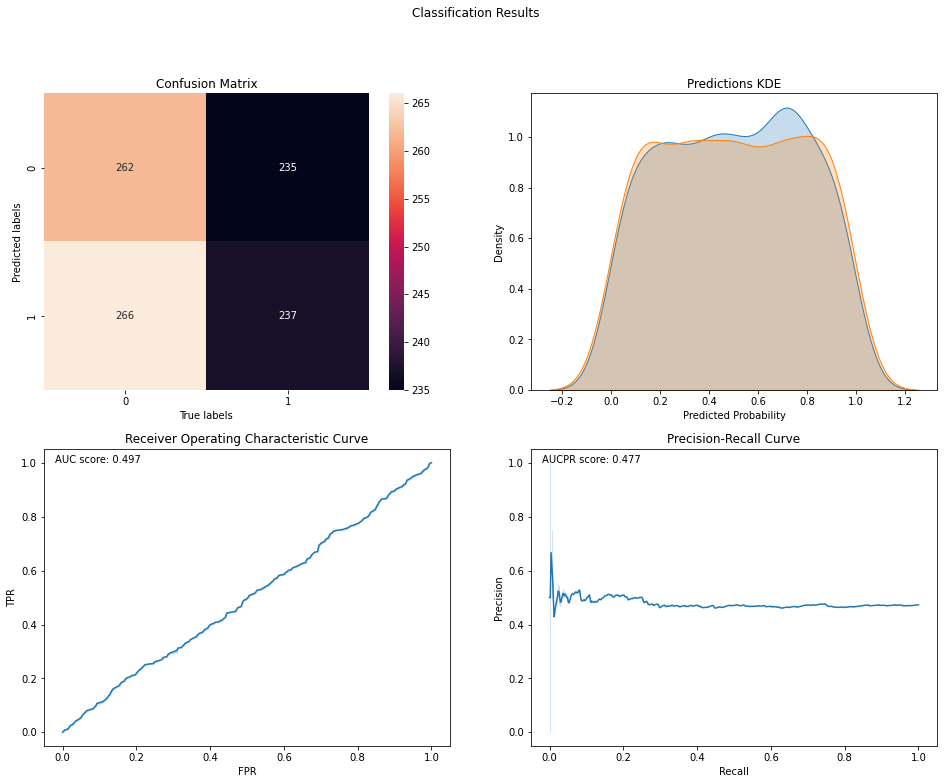

In [4]:
binary_classification_eval(y_true,y_pred)